### Get Transition Probabilities

In [42]:
from collections import defaultdict
from itertools import product, combinations, chain
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import random
# same action and same state success or failure amy lead to the same next state, we aggeragert data

In [43]:
def getPossibleStates(edges, max_age):
    """
    Returns: list of states, where each state is a tuple of ((edge), age)
    """
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))

    all_states = [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

    return all_states

def getAgedStates(state, maxAge):
    """
    Returns:
        New state as a tuple of ((edge), age) pairs
    """
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))  # not entangled
        else:
            new_age = age + 1
            if new_age <= maxAge:
                new_state.append((edge, new_age))
            else:
                new_state.append((edge, -1))  # entanglement expired

    return tuple(sorted(new_state))


def generateAllOutcomes(state, pGen):
    empty_edges = [edge for edge, age in state if age == -1]
    outcomes = []

    for pattern in product([0, 1], repeat=len(empty_edges)):
        prob = 1.0
        new_state = []

        # First, update the empty edges based on entanglement outcomes
        outcome_map = {}
        for (edge, outcome) in zip(empty_edges, pattern):
            if outcome:
                prob *= pGen
                outcome_map[edge] = 1
            else:
                prob *= (1 - pGen)
                outcome_map[edge] = -1

        # Now build the full new state
        for edge, age in state:
            if edge in outcome_map:
                new_state.append((edge, outcome_map[edge]))
            else:
                new_state.append((edge, age))  # unchanged

        outcomes.append((tuple(sorted(new_state)), prob))

    return outcomes

def generateAllSwappingOutcomes(state, goalEdges, pSwap):
    """
    Generate all possible outcomes from swapping operations or doing nothing.
    Can attempt multiple non-overlapping swaps simultaneously.
    """
    def find_path(current, target, visited):
        if current == target:
            return [current]
        visited.add(current)
        for next_node in graph.get(current, []):
            if next_node not in visited:
                path = find_path(next_node, target, visited)
                if path:
                    return [current] + path
        return None

    # First find all possible individual swap attempts
    swap_attempts = []
    entangled_edges = [(edge, age) for edge, age in state if age > 0]
    
    # Create graph once for all path finding
    graph = {}
    for (edge, _) in entangled_edges:
        if edge[0] not in graph: graph[edge[0]] = []
        if edge[1] not in graph: graph[edge[1]] = []
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Find all possible paths for each goal
    for goal_edge in goalEdges:
        start, end = goal_edge
        path = find_path(start, end, set())
        
        if path and len(path) > 1:
            path_edges = list(zip(path[:-1], path[1:]))
            used_edges = []
            for p_edge in path_edges:
                for e, age in entangled_edges:
                    if (e[0] == p_edge[0] and e[1] == p_edge[1]) or \
                       (e[0] == p_edge[1] and e[1] == p_edge[0]):
                        used_edges.append((e, age))
            
            swap_attempts.append({
                'goal': goal_edge,
                'used_edges': used_edges,
                'num_swaps': len(path_edges) - 1
            })
    
    outcomes = []
    
    # Case 1: Do nothing
    outcomes.append((state, 1.0, None))
    
    # Case 2: Try all possible combinations of non-overlapping swaps
    for r in range(1, len(swap_attempts) + 1):
        for attempt_combo in combinations(swap_attempts, r):
            # Check if attempts are compatible (don't share edges)
            all_used_edges = set()
            edge_overlap = False
            for attempt in attempt_combo:
                attempt_edges = set(e for e, _ in attempt['used_edges'])
                if any(e in all_used_edges for e in attempt_edges):
                    edge_overlap = True
                    break
                all_used_edges.update(attempt_edges)
            
            if edge_overlap:
                continue
                
            # Generate all success/failure combinations for this set of attempts
            for success_pattern in product([True, False], repeat=len(attempt_combo)):
                new_state = []
                total_prob = 1.0
                achieved_goals = []
                
                # Calculate probability and track achieved goals
                for attempt, succeeded in zip(attempt_combo, success_pattern):
                    prob = pSwap ** attempt['num_swaps'] if succeeded else \
                          (1 - pSwap ** attempt['num_swaps'])
                    total_prob *= prob
                    if succeeded:
                        achieved_goals.append((attempt['goal'], True))
                    else:
                        achieved_goals.append((attempt['goal'], False))
                
                # Create new state
                for edge, age in state:
                    if any(edge == e for attempt in attempt_combo 
                          for e, _ in attempt['used_edges']):
                        new_state.append((edge, -1))  # Used edges become unentangled
                    else:
                        new_state.append((edge, age))  # Other edges remain unchanged
                
                new_state = tuple(sorted(new_state))
                outcomes.append((new_state, total_prob, achieved_goals))
    
    return outcomes

def getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        List of (new_state, probability, achieved_goals) tuples
    """
    all_transitions = []
    
    # Get all possible swap action outcomes
    swap_outcomes = generateAllSwappingOutcomes(state, goalEdges, pSwap)
    
    # For each swap outcome, generate all possible generation outcomes
    for swap_state, swap_prob, achieved_goals in swap_outcomes:
        # Skip if swap probability is 0
        if swap_prob == 0:
            continue
            
        # First age the state
        aged_state = getAgedStates(swap_state, maxAge)
        
        # Then get all possible generation outcomes
        gen_outcomes = generateAllOutcomes(aged_state, pGen)
        
        # Combine the probabilities and add to transitions
        for final_state, gen_prob in gen_outcomes:
            # Skip if either probability is 0
            if gen_prob == 0:
                continue
                
            all_transitions.append((
                final_state,
                swap_prob * gen_prob,
                achieved_goals
            ))
    
    return all_transitions

def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        Dictionary mapping state -> list of (next_state, prob, achieved_goals)
    """
    # Get all possible states
    all_states = getPossibleStates(edges, maxAge)
    transitions = {}
    
    # For each state, calculate all possible transitions
    for state in all_states:
        transitions[state] = getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge)
    
    return transitions

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_quantum_network(edges, goal_edges):
    # Create graph
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Use spring layout with adjusted parameters for better spacing
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the network
    # Regular edges
    nx.draw_networkx_edges(G, pos, 
                          edge_color='gray',
                          width=2)
    
    # Goal edges (drawn curved and in red)
    for goal in goal_edges:
        nx.draw_networkx_edges(G, pos,
                             edgelist=[goal],
                             edge_color='red',
                             width=2,
                             arrows=True,
                             connectionstyle=f'arc3, rad=0.3',
                             style='dashed')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightblue',
                          node_size=500)
    
    # Add node labels
    nx.draw_networkx_labels(G, pos)
    
    plt.title("Quantum Network Topology")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function


### Value Iteration


In [46]:

edges = [(0, 1), (1, 2), (2, 3)]
goalEdges = [(0, 2), (0, 3)]
pSwap = 0.99
pGen = 0.99
maxAge = 2

# Value iteration parameters
gamma = 0.95
epsilon = 0.001
max_iterations = 100
initial_state = tuple((edge, -1) for edge in edges) # For iteration / simulation

all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)   


Converged after 304 iterations


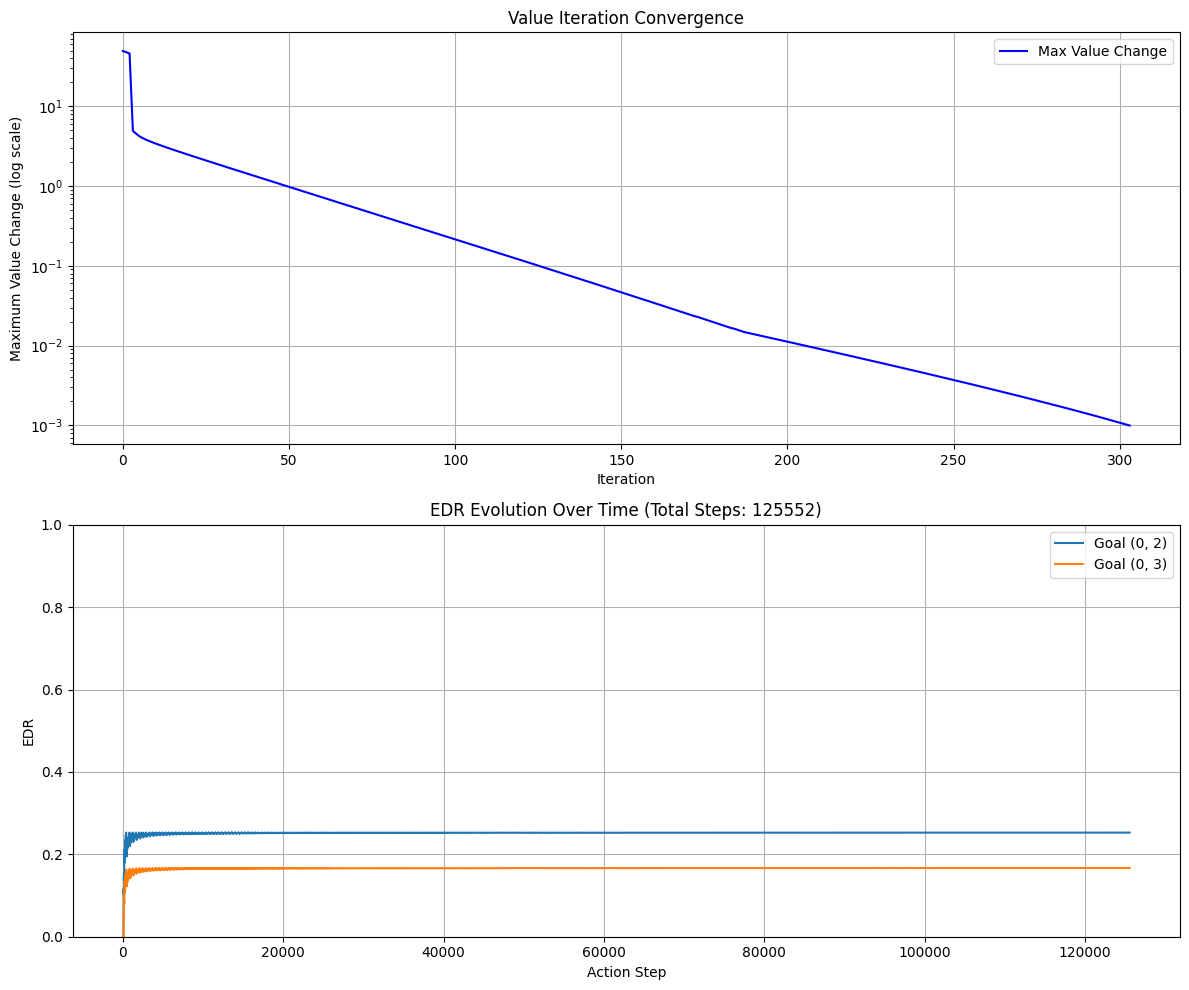

0.99 0.99 2 [(0, 1), (1, 2), (2, 3)] [(0, 2), (0, 3)]

=== Final EDR Statistics ===
Goal (0, 2): EDR = 0.252748
  - Successes: 3611.52
  - Total timesteps: 14289.00
Goal (0, 3): EDR = 0.166814
  - Successes: 2383.60
  - Total timesteps: 14289.00
Total number of EDR data points: 125552


In [47]:
from collections import defaultdict
import matplotlib.pyplot as plt
import math

def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0

    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            start, end = goal_edge
            num_edges = abs(end - start)
            instant_rate = pSwap ** (num_edges - 1)

            edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))

            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
    return total_reward




# Initialize value function and EDR tracking
values = {state: 0 for state in all_transitions.keys()}
policy = {state: None for state in all_transitions.keys()}
convergence_data = []

# Global tracking variables
total_timesteps = 1
goal_success_counts = {goal: 0 for goal in goalEdges}
edr_history = {goal: [] for goal in goalEdges}

# Value iteration parameters
gamma = 0.99
epsilon = 0.001
max_iterations = 10000

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Run value iteration
for iteration in range(max_iterations):
    delta = 0
    new_values = values.copy()
    
    # Update value for each state
    for state in all_transitions.keys():
        action_values = defaultdict(float)
        
        for next_state, prob, achieved_goals in all_transitions[state]:
            # Simulate timestep for EDR tracking
            total_timesteps += prob
            
            # Update EDR tracking for this specific transition
            if achieved_goals is not None:
                for goal_edge, success in achieved_goals:
                    if success:
                        goal_success_counts[goal_edge] += prob
            
            # Calculate reward using current EDR values
            immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
            future_value = gamma * values[next_state]
            action_values[str(achieved_goals)] += prob * (immediate_reward + future_value)
            # Update EDR history after each transition
            for goal in goalEdges:
                current_edr = goal_success_counts[goal] / total_timesteps
                edr_history[goal].append(current_edr)
        
        if action_values:
            best_action = max(action_values.items(), key=lambda x: x[1])
            new_values[state] = best_action[1]
            policy[state] = eval(best_action[0]) if best_action[0] != 'None' else None
            delta = max(delta, abs(new_values[state] - values[state]))
    
    # Update values
    values = new_values
    convergence_data.append(delta)
    
    # Check for convergence
    if delta < epsilon:
        print(f"Converged after {iteration + 1} iterations")
        break

# Plot convergence
ax1.plot(convergence_data, 'b-', label='Max Value Change')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Maximum Value Change (log scale)')
ax1.set_title('Value Iteration Convergence')
ax1.grid(True)
ax1.legend()

# Plot EDR
for goal, edr_values in edr_history.items():
    ax2.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
ax2.set_xlabel('Action Step')
ax2.set_ylabel('EDR')
ax2.set_title(f'EDR Evolution Over Time (Total Steps: {len(edr_history[goalEdges[0]])})')
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 1)  # Set y-axis limits between 0 and 1

plt.tight_layout()
plt.show()

print(pSwap, pGen, maxAge, edges, goalEdges)
# Print final EDR statistics
print("\n=== Final EDR Statistics ===")
for goal in goalEdges:
    final_edr = goal_success_counts[goal] / total_timesteps
    print(f"Goal {goal}: EDR = {final_edr:.6f}")
    print(f"  - Successes: {goal_success_counts[goal]:.2f}")
    print(f"  - Total timesteps: {total_timesteps:.2f}")
print(f"Total number of EDR data points: {len(edr_history[goalEdges[0]])}")

### **Evaluate with EDR**

Parameters: pSwap=0.99, pGen=0.99, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3)], goals=[(0, 2), (0, 3)]

=== Final EDR Statistics (Policy Evaluation) ===
Goal (0, 2): EDR = 0.313169
  - Successes: 3132.00
  - Total timesteps: 10001.00
Goal (0, 3): EDR = 0.317868
  - Successes: 3179.00
  - Total timesteps: 10001.00
Total number of EDR data points: 10000

Average Episode Reward: 196.1230


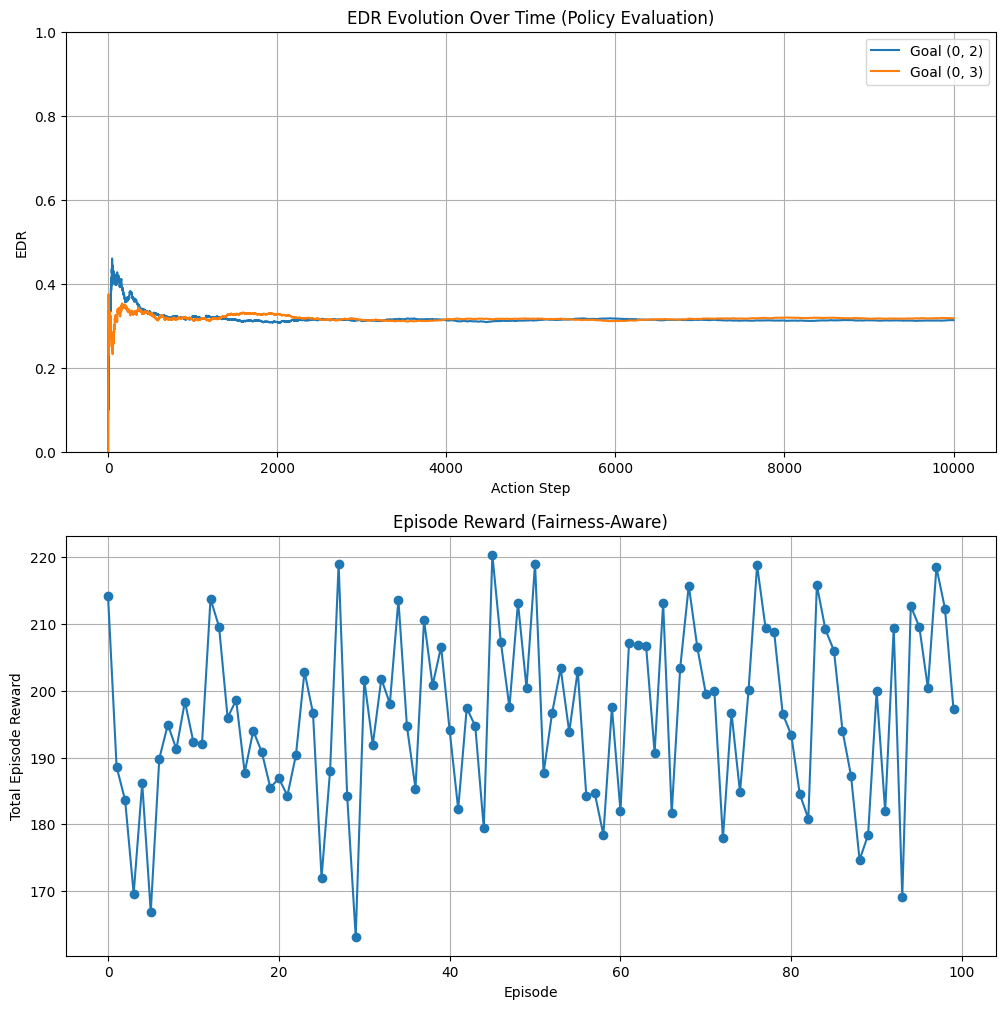

In [48]:

# Simulation params
num_episodes = 100
max_steps_per_episode = 100

# Tracking variables
total_timesteps = 1
goal_success_counts = {goal: 0 for goal in goalEdges}
edr_history = {goal: [] for goal in goalEdges}
reward_history = []

# Evaluation loop
for episode in range(num_episodes):
    state = tuple((edge, -1) for edge in edges)  # initial empty state
    episode_reward = 0

    for step in range(max_steps_per_episode):
        # Use trained policy
        best_next_state = policy[state]
        candidates = [t for t in all_transitions[state] if t[0] == best_next_state]
        if not candidates:
            transition = random.choices(all_transitions[state], weights=[t[1] for t in all_transitions[state]])[0]
        else:
            transition = candidates[0]

        next_state, prob, achieved_goals = transition

        # Simulate timestep
        total_timesteps += 1

        # Update goal success counts
        if achieved_goals is not None:
            for goal_edge, success in achieved_goals:
                if success:
                    goal_success_counts[goal_edge] += 1

        # Calculate and accumulate reward
        immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
        episode_reward += immediate_reward

        # Update EDR tracking
        for goal in goalEdges:
            current_edr = goal_success_counts[goal] / total_timesteps
            edr_history[goal].append(current_edr)

        # Transition
        state = next_state

    reward_history.append(episode_reward)

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot EDR evolution
for goal, edr_values in edr_history.items():
    ax1.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
ax1.set_xlabel('Action Step')
ax1.set_ylabel('EDR')
ax1.set_title('EDR Evolution Over Time (Policy Evaluation)')
ax1.grid(True)
ax1.legend()
ax1.set_ylim(0, 1)

# Plot total reward per episode
ax2.plot(range(len(reward_history)), reward_history, marker='o')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Episode Reward')
ax2.set_title('Episode Reward (Fairness-Aware)')
ax2.grid(True)

# Print stats
print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
print(f"Network: edges={edges}, goals={goalEdges}")

print("\n=== Final EDR Statistics (Policy Evaluation) ===")
for goal in goalEdges:
    final_edr = goal_success_counts[goal] / total_timesteps
    print(f"Goal {goal}: EDR = {final_edr:.6f}")
    print(f"  - Successes: {goal_success_counts[goal]:.2f}")
    print(f"  - Total timesteps: {total_timesteps:.2f}")

print(f"Total number of EDR data points: {len(edr_history[goalEdges[0]])}")
print(f"\nAverage Episode Reward: {np.mean(reward_history):.4f}")


In [49]:
# from collections import defaultdict
# import matplotlib.pyplot as plt
# import numpy as np
# import math
# import random

# def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
#     if achieved_goals is None:
#         return 0

#     total_reward = 0
#     for goal_edge, success in achieved_goals:
#         if success:
#             start, end = goal_edge
#             num_edges = abs(end - start)
#             instant_rate = pSwap ** (num_edges - 1)

#             edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))

#             if instant_rate > 0 and edr > 0:
#                 total_reward += np.log(instant_rate / edr)
#     return total_reward

# def get_attempted_goal(next_state, achieved_goals):
#     """Identify which goal the action is attempting to achieve based on the state"""
#     if achieved_goals is None:
#         return None
    
#     for goal_edge, success in achieved_goals:
#         return goal_edge  # Return the first goal being attempted
#     return None

# def choose_best_action(state, all_transitions, values, goal_success_counts, total_timesteps, debug=True):
#     best_action = None
#     best_value = float('-inf')
    
#     if debug:
#         print("\nCurrent state:", state)
#         print(f"Current EDRs: {[(goal, goal_success_counts[goal]/total_timesteps) for goal in goalEdges]}")
#         print("\nEvaluating transitions:")
    
#     # Look at all possible transitions from current state
#     for transition in all_transitions[state]:
#         next_state, prob, achieved_goals = transition
        
#         # Calculate immediate reward based on EDR
#         immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
        
#         # Get future reward from V-table and scale it by EDR of attempted goal
#         future_reward = values.get(next_state, 0)
#         attempted_goal = get_attempted_goal(next_state, achieved_goals)
        
#         if attempted_goal:
#             goal_edr = max(0.0001, goal_success_counts[attempted_goal] / max(1, total_timesteps))
#             # Scale future reward by EDR to balance with immediate rewards
#             future_reward = future_reward / goal_edr
        
#         # Total value is immediate + scaled future reward
#         total_value = immediate_reward + future_reward
        
#         if debug:
#             print(f"\nTransition to: {next_state}")
#             print(f"  Achieved goals: {achieved_goals}")
#             print(f"  Attempted goal: {attempted_goal}")
#             if attempted_goal:
#                 print(f"  Goal EDR: {goal_edr:.4f}")
#             print(f"  Immediate reward: {immediate_reward:.4f}")
#             print(f"  Future reward (scaled): {future_reward:.4f}")
#             print(f"  Total value: {total_value:.4f}")
        
#         if total_value > best_value:
#             best_value = total_value
#             best_action = transition
#             if debug:
#                 print(f"  -> New best action!")
    
#     if debug:
#         print(f"\nChosen action:")
#         print(f"  Next state: {best_action[0]}")
#         print(f"  Achieved goals: {best_action[2]}")
#         print(f"  Total value: {best_value:.4f}")
    
#     return best_action

# # Simulation params
# num_episodes = 10
# max_steps_per_episode = 100

# # Tracking variables
# total_timesteps = 1
# goal_success_counts = {goal: 0 for goal in goalEdges}
# edr_history = {goal: [] for goal in goalEdges}
# reward_history = []

# # Track goal-specific rewards and attempts
# goal_immediate_rewards = {goal: [] for goal in goalEdges}
# goal_future_rewards = {goal: [] for goal in goalEdges}
# goal_attempts = {goal: 0 for goal in goalEdges}
# goal_successes = {goal: 0 for goal in goalEdges}

# # Evaluation loop
# for episode in range(num_episodes):
#     state = tuple((edge, -1) for edge in edges)  # initial empty state
#     episode_reward = 0

#     for step in range(max_steps_per_episode):
#         transition = choose_best_action(
#             state, 
#             all_transitions, 
#             values,
#             goal_success_counts, 
#             total_timesteps
#         )
        
#         next_state, prob, achieved_goals = transition
#         attempted_goal = get_attempted_goal(next_state, achieved_goals)

#         # Simulate timestep
#         total_timesteps += 1

#         # Track attempts and successes
#         if achieved_goals is not None:
#             for goal_edge, success in achieved_goals:
#                 goal_attempts[goal_edge] += 1
#                 if success:
#                     goal_success_counts[goal_edge] += 1
#                     goal_successes[goal_edge] += 1
                    
#                     # Track rewards
#                     current_edr = goal_success_counts[goal_edge] / total_timesteps
#                     instant_rate = pSwap ** (abs(goal_edge[1] - goal_edge[0]) - 1)
#                     goal_reward = instant_rate / max(0.0001, current_edr)
#                     goal_immediate_rewards[goal_edge].append(goal_reward)
#                     goal_future_rewards[goal_edge].append(values.get(next_state, 0))

#         # Calculate and accumulate reward
#         immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
#         episode_reward += immediate_reward

#         # Update EDR tracking
#         for goal in goalEdges:
#             current_edr = goal_success_counts[goal] / total_timesteps
#             edr_history[goal].append(current_edr)

#         # Transition
#         state = next_state

#     reward_history.append(episode_reward)

# # Visualization
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# # Plot EDR evolution
# for goal, edr_values in edr_history.items():
#     ax1.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
# ax1.set_xlabel('Action Step')
# ax1.set_ylabel('EDR')
# ax1.set_title('EDR Evolution Over Time')
# ax1.grid(True)
# ax1.legend()
# ax1.set_ylim(0, 1)

# # Plot total reward per episode
# ax2.plot(range(len(reward_history)), reward_history, marker='o')
# ax2.set_xlabel('Episode')
# ax2.set_ylabel('Total Episode Reward')
# ax2.set_title('Episode Reward')
# ax2.grid(True)

# # Plot reward components by goal
# for goal in goalEdges:
#     if goal_immediate_rewards[goal]:
#         ax3.plot(range(len(goal_immediate_rewards[goal])), 
#                  goal_immediate_rewards[goal], 
#                  label=f'Immediate {goal}', linestyle='--')
#         ax3.plot(range(len(goal_future_rewards[goal])), 
#                  goal_future_rewards[goal], 
#                  label=f'Future {goal}', linestyle=':')
# ax3.set_xlabel('Success Events')
# ax3.set_ylabel('Reward Components')
# ax3.set_title('Immediate vs Future Rewards by Goal')
# ax3.grid(True)
# ax3.legend()

# # Plot attempt/success ratio
# goals = list(goalEdges)
# attempts = [goal_attempts[g] for g in goals]
# successes = [goal_successes[g] for g in goals]
# x = range(len(goals))
# width = 0.35

# ax4.bar(x, attempts, width, label='Attempts')
# ax4.bar([i + width for i in x], successes, width, label='Successes')
# ax4.set_xlabel('Goals')
# ax4.set_ylabel('Count')
# ax4.set_title('Attempts vs Successes by Goal')
# ax4.set_xticks([i + width/2 for i in x])
# ax4.set_xticklabels([str(g) for g in goals])
# ax4.legend()

# plt.tight_layout()

# # Print stats
# print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
# print(f"Network: edges={edges}, goals={goalEdges}")

# print("\n=== Final EDR Statistics ===")
# for goal in goalEdges:
#     final_edr = goal_success_counts[goal] / total_timesteps
#     print(f"Goal {goal}: EDR = {final_edr:.6f}")
#     print(f"  - Successes: {goal_success_counts[goal]:.2f}")
#     print(f"  - Total timesteps: {total_timesteps:.2f}")
#     print(f"  - Attempts: {goal_attempts[goal]}")
#     print(f"  - Success rate: {goal_successes[goal]/max(1, goal_attempts[goal]):.4f}")

# print(f"\nTotal number of EDR data points: {len(edr_history[goalEdges[0]])}")
# print(f"Average Episode Reward: {np.mean(reward_history):.4f}")

# # Print reward component analysis
# print("\n=== Reward Component Analysis ===")
# for goal in goalEdges:
#     imm_rewards = goal_immediate_rewards[goal]
#     fut_rewards = goal_future_rewards[goal]
#     if imm_rewards:
#         print(f"\nGoal {goal}:")
#         print(f"  Immediate rewards: avg={np.mean(imm_rewards):.4f}, max={max(imm_rewards):.4f}")
#         print(f"  Future rewards: avg={np.mean(fut_rewards):.4f}, max={max(fut_rewards):.4f}")
#         print(f"  Ratio (immediate/future): {np.mean(imm_rewards)/np.mean(fut_rewards):.4f}")